In [558]:
%pylab inline

import pickle
import scipy.stats as stats
import scipy.optimize as opt
import pandas as pd
import deribit_api as api
import strategy as strat

tableau = pickle.load(open('tableau.colors', 'rb'))
rcParams['axes.prop_cycle'] = cycler('color',tableau)
rcParams["axes.grid"] = True
rcParams["lines.linewidth"] = 2.5
rcParams["figure.figsize"] = (10,7)

Populating the interactive namespace from numpy and matplotlib


In [31]:
def BSsetup(S, K, T, sigma, r, c):
    d1 = (np.log(S/K) + (r - c + sigma**2/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    return d1,d2

def BScall(S, K, T, sigma, r, c):
    d1, d2 = BSsetup(S, K, T, sigma, r, c)
    return stats.norm.cdf(d1)*S - stats.norm.cdf(d2)*K*np.exp(-r*T)

def BSput(S, K, T, sigma, r, c):
    d1, d2 = BSsetup(S, K, T, sigma, r, c)
    return stats.norm.cdf(-d2)*K*np.exp(-r*T) - stats.norm.cdf(-d1)*S

def BSvol(S, K, T, r, c, V, call=True):
    value = lambda sigma: BScall(S,K,T,sigma,r,c) if call else BSput(S,K,T,sigma,r,c)
    return opt.brentq(lambda sigma: value(sigma)-V, 0.01, 10.0)

In [173]:
def convert_GMT_EST(date):
    return pd.to_datetime(date).tz_localize('GMT').tz_convert('EST')
def now_EST():
    return pd.to_datetime(datetime.datetime.today()).tz_localize('EST')
    
# Expiry and now in same timezone
def time_to_expiry(expiry, now):
    return (expiry - now).total_seconds()/3600/24/365

In [8]:
keys = open('keys.txt', 'r').read().split('\n')[:-1]
client = api.RestClient(keys[0], keys[1])

In [10]:
instruments = client.getinstruments()

In [290]:
expiry_codes = {'2018-03-30 08:00:00 GMT': '30MAR18',
                '2018-01-26 08:00:00 GMT': '26JAN18',
                '2018-01-05 08:00:00 GMT': '5JAN18'}

In [529]:
# Pull OTM option prices 
expiry = '30MAR18'
options = [inst for inst in instruments if inst['kind'] == 'option' and expiry_codes[inst['expiration']] == expiry]
S = client.index()['btc']
OTM = [opt for opt in options if (opt['optionType'] == 'call' and opt['strike'] > S) or \
                                 (opt['optionType'] == 'put' and opt['strike'] <= S)]
for i in range(len(OTM)):
    book = client.getorderbook(OTM[i]['instrumentName'])
    bid = book['bids'][0]['price'] if len(book['bids']) > 0 else 0
    ask = book['asks'][0]['price'] if len(book['asks']) > 0 else 0
    OTM[i]['bid'] = bid
    OTM[i]['ask'] = ask
OTM = sorted(OTM, key=lambda x: x['strike'])
T = time_to_expiry(convert_GMT_EST(OTM[0]['expiration']), convert_GMT_EST(book['tstamp']*1e6))

In [530]:
# Solve for bid and ask vols
bid_vols = np.zeros(len(OTM))
ask_vols = np.zeros(len(OTM))
for i in range(len(OTM)):
    K = OTM[i]['strike']
    r = 0.0; c = 0.0
    is_call = (OTM[i]['instrumentName'][-1] == 'C')
    bid_vols[i] = BSvol(S, K, T, r, c, S*OTM[i]['bid'], call=is_call) if OTM[i]['bid'] != 0 else 0
    ask_vols[i] = BSvol(S, K, T, r, c, S*OTM[i]['ask'], call=is_call) if OTM[i]['ask'] != 0 else 0

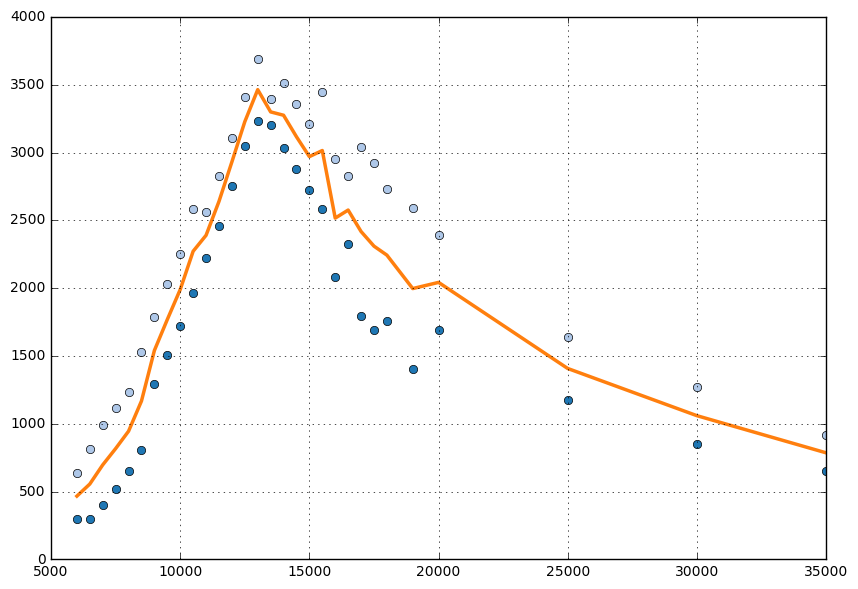

In [559]:
# Plot prices
bids = np.array([S*opt['bid'] for opt in OTM])
asks = np.array([S*opt['ask'] for opt in OTM])
strikes = np.array([opt['strike'] for opt in OTM])

clean_bids = [i for i in range(len(bids)) if bids[i] != 0]
clean_asks = [i for i in range(len(asks)) if asks[i] != 0]
clean_mids = [i for i in range(len(asks)) if i in clean_bids and i in clean_asks]

plot(strikes[clean_bids], bids[clean_bids], 'o')
plot(strikes[clean_asks], asks[clean_asks], 'o')
plot(strikes[clean_mids], 0.5*(bids[clean_mids]+asks[clean_mids]))

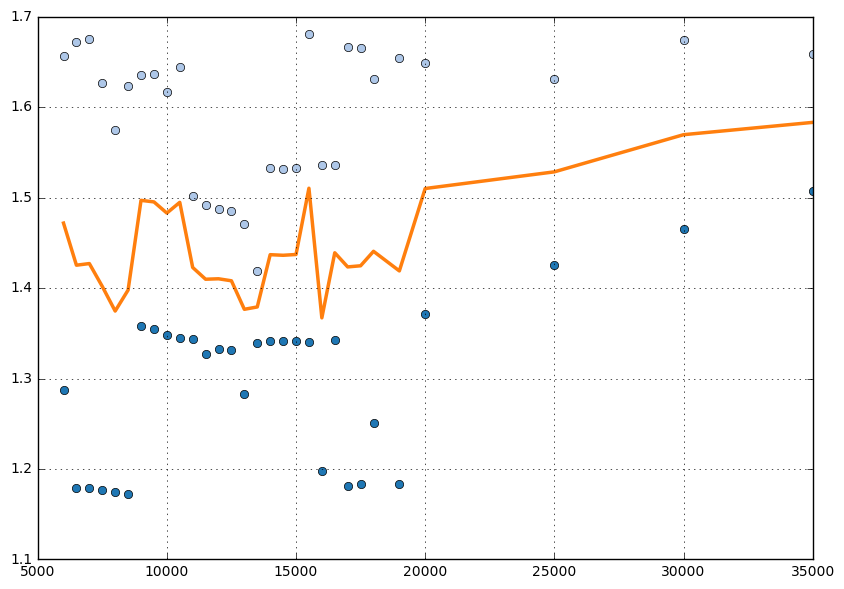

In [560]:
# Plot vols
plot(strikes[clean_bids], bid_vols[clean_bids], 'o')
plot(strikes[clean_asks], ask_vols[clean_asks], 'o')
plot(strikes[clean_mids], 0.5*(bid_vols[clean_mids]+ask_vols[clean_mids]))

In [533]:
# Surface functional form
Sigma_explicit = lambda lK,pATM,pSKEW,pVoV: pATM -pSKEW*lK + pVoV*lK**2
Sigma = lambda lK,surface: Sigma_explicit(lK,surface[0],surface[1],surface[2])

In [534]:
# Fit surface
log_strikes = np.log(strikes/S)
p = opt.curve_fit(Sigma_explicit, log_strikes[clean_mids], 0.5*(bid_vols[clean_mids]+ask_vols[clean_mids]))[0]
p

array([ 1.42496612, -0.04779865,  0.1200202 ])

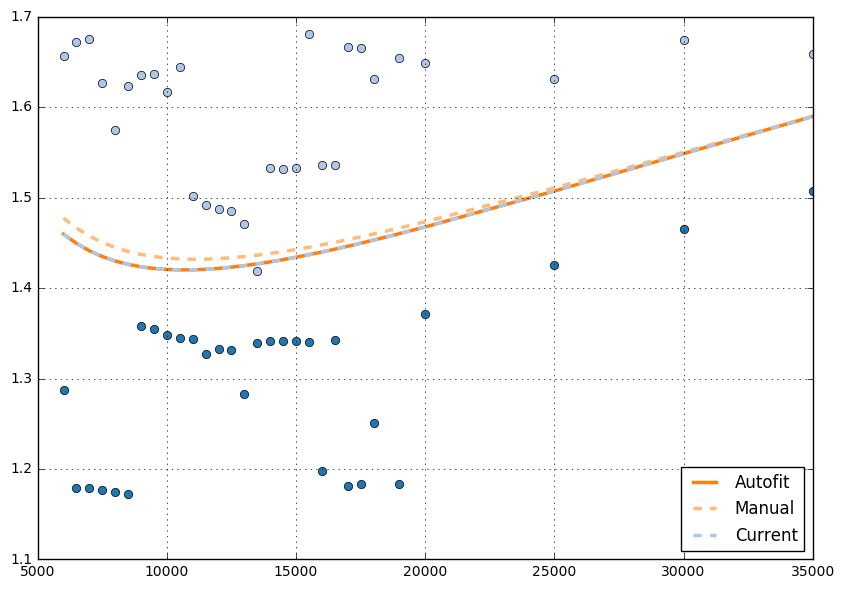

In [591]:
# Plot surface, show tweaks
pATM_shift  = 0.01
pSKEW_shift = 0.01
pVoV_shift  = 0.0

x = strikes

plot(x[clean_bids], bid_vols[clean_bids], 'o')
plot(x[clean_asks], ask_vols[clean_asks], 'o')

# Autofit
plot(x, Sigma_explicit(log_strikes,p[0],p[1],p[2]), label='Autofit')

# Modified autofit
plot(x, Sigma_explicit(log_strikes,p[0]+pATM_shift,p[1]+pSKEW_shift,p[2]+pVoV_shift), '--', label='Manual')

# Existing surface
plot(x, Sigma(log_strikes,my_surface[expiry_codes[OTM[0]['expiration']]]), '--', color=tableau[1], label='Current')

legend(loc='lower right')

In [592]:
# Save my surface
my_surface_slice = [p[0]+pATM_shift, p[1]+pSKEW_shift, p[2]+pVoV_shift]
if my_surface is None:
    my_surface = {}
my_surface[expiry] = my_surface_slice
my_surface

{'26JAN18': [1.4163419586896799, 0.23794189619424291, 0.98630170061870892],
 '30MAR18': [1.4349661212694413, -0.037798647478532656, 0.12002020076431588],
 '5JAN18': [1.8519018343784592, 0.12457911011554534, 0.34209931182694264]}

In [576]:
def plot_surface(surface,expiry,bench):
    strikes = np.arange(40)*500+4000
    log_strikes = np.log(strikes/bench)
    sigma = Sigma(log_strikes, surface[expiry])
    plot(strikes,sigma,label=expiry)
    legend(loc='upper right')

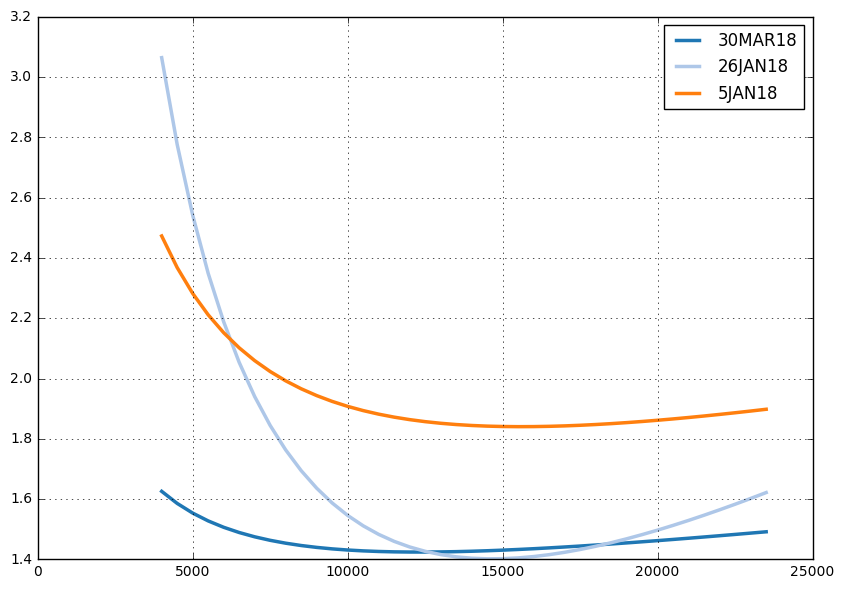

In [587]:
plot_surface(my_surface,'30MAR18',S)
plot_surface(my_surface,'26JAN18',S)
plot_surface(my_surface,'5JAN18',S)

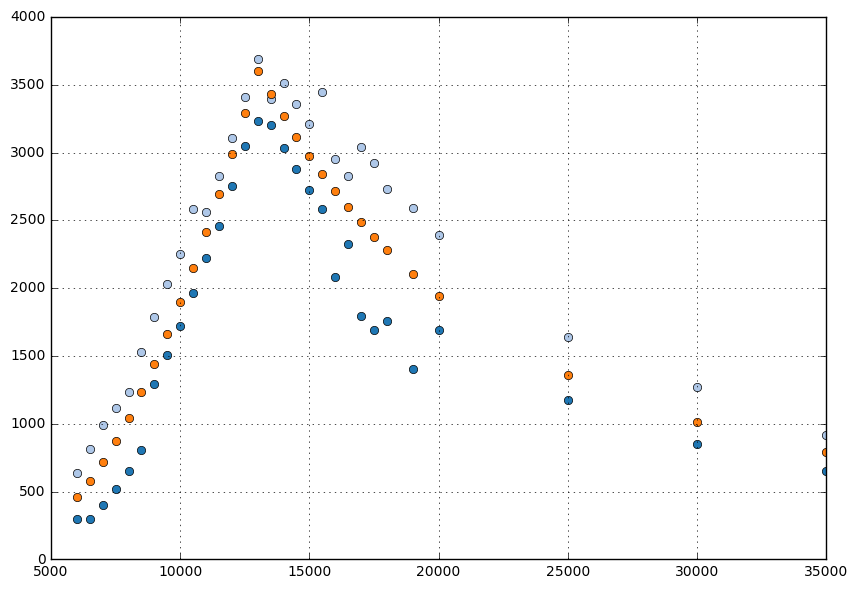

In [593]:
my_prices = np.zeros(len(strikes))
for i in range(len(strikes)):
    sigma = Sigma(np.log(strikes[i]/S), my_surface_slice)
    if strikes[i] <= S:
        my_prices[i] = BSput(S, strikes[i], T, sigma, 0.0, 0.0)
    else:
        my_prices[i] = BScall(S, strikes[i], T, sigma, 0.0, 0.0)

plot(strikes[clean_bids], bids[clean_bids], 'o')
plot(strikes[clean_asks], asks[clean_asks], 'o')
plot(strikes, my_prices, 'o')

In [446]:
t = time_to_expiry(convert_GMT_EST(OTM[0]['expiration']), now_EST())
index  = client.index()['btc']
strike = 17000
sigma  = Sigma(np.log(strike/index), my_surface[expiry_codes[OTM[0]['expiration']]])
BScall(index, strike, t, sigma, 0.0, 0.0)

793.41733367507868

In [607]:
def PV(option, surface, overrides={}):
    expiry = expiry_codes[option['expiration']]
    K = option['strike']
    is_call = option['instrumentName'][-1] == 'C'
    T = time_to_expiry(convert_GMT_EST(option['expiration']), now_EST())
    sigma = Sigma(np.log(strike/index), surface[expiry])
    func = BScall if is_call else BSput
    
    S = overrides['spot']
    if overrides.get('vol') is not None:
        sigma = overrides['vol']
    if overrides.get('time') is not None:
        T = overrides.get('time')
    
    return func(S,K,T,sigma,0.0,0.0)

def delta(option, surface, overrides={}):
    expiry = expiry_codes[option['expiration']]
    S = overrides['spot']
    dS = 0.01
    overrides_H = overrides.copy(); overrides_H['spot'] = S*(1+dS/2)
    overrides_L = overrides.copy(); overrides_L['spot'] = S*(1-dS/2)
    pv_H = PV(option, surface, overrides_H,)
    pv_L = PV(option, surface, overrides_L)
    return (pv_H - pv_L)/(dS/0.01)

def gamma(option, surface, overrides={}):
    expiry = expiry_codes[option['expiration']]
    S = overrides['spot']
    dS = 0.01
    overrides_H = overrides.copy(); overrides_H['spot'] = S*(1+dS/2)
    overrides_L = overrides.copy(); overrides_L['spot'] = S*(1-dS/2)
    delta_H = delta(option, surface, overrides_H)
    delta_L = delta(option, surface, overrides_L)
    return (delta_H - delta_L)/(dS/0.01)

def vega(option, surface, overrides={}):
    expiry = expiry_codes[option['expiration']]
    sigma = Sigma(np.log(strike/index), surface[expiry])
    dSigma = 0.01
    overrides_H = overrides.copy(); overrides_H['vol'] = sigma+dSigma
    overrides_L = overrides.copy(); overrides_L['vol'] = sigma-dSigma
    pv_H = PV(option, surface, overrides_H)
    pv_L = PV(option, surface, overrides_L)
    return (pv_H - pv_L)/(dSigma/0.01)

def theta(option, surface, overrides={}):
    expiry = expiry_codes[option['expiration']]
    T = time_to_expiry(convert_GMT_EST(option['expiration']), now_EST())
    dT = 1/365
    overrides_H = overrides.copy(); overrides_H['time'] = T-dT
    pv_H = PV(option, surface, overrides_H)
    pv_L = PV(option, surface, overrides)
    return pv_H - pv_L

In [ ]:
S = client.index()['btc']

In [580]:
options = {'BTC-30MAR18-20000-C': -1.00,
           'BTC-30MAR18-17000-C':  1.00,
           'BTC-30MAR18-35000-C': -1.00,
           'BTC-30MAR18-7000-P':   1.50,
           'BTC-30MAR18-9500-P':  -0.70,
           'BTC-5JAN18-17000-C':  -1.00}
portfolio = sorted([opt for opt in instruments if opt['instrumentName'] in options.keys()], 
                   key=lambda opt: opt['instrumentName'])

In [594]:
quantities = np.array([options[opt['instrumentName']] for opt in portfolio])
values = np.array([PV(opt, my_surface, overrides={'spot': S}) for opt in portfolio])
deltas = np.array([delta(opt, my_surface, overrides={'spot': S}) for opt in portfolio])
gammas = np.array([gamma(opt, my_surface, overrides={'spot': S}) for opt in portfolio])
vegas = np.array([vega(opt, my_surface, overrides={'spot': S}) for opt in portfolio])
thetas = np.array([theta(opt, my_surface, overrides={'spot': S}) for opt in portfolio])

In [595]:
df = pd.DataFrame(columns=['Px','Q','PV','Delta','Gamma','Vega','Theta'])
for idx in range(len(portfolio)):
    instrument = portfolio[idx]
    row = pd.Series()
    row['Expiry'] = expiry_codes[instrument['expiration']]
    row['PutCall'] = 'call' if instrument['instrumentName'][-1] == 'C' else 'put'
    row['Strike'] = instrument['strike']
    row['Px'] = round(values[idx],2)
    row['Q']  = quantities[idx]
    row['PV']    = values[idx]*row['Q']
    row['Delta'] = deltas[idx]*row['Q']
    row['Gamma'] = gammas[idx]*row['Q']
    row['Vega']  = vegas[idx]*row['Q']
    row['Theta'] = thetas[idx]*row['Q']
    row.name = instrument['instrumentName']
    df = df.append(row)
total = df.sum()
total.name = 'total'
total['Expiry'] = ''
total['PutCall'] = ''
total['Strike'] = ''
total['Px'] = S
df = df.append(total)[['Expiry','Strike','PutCall','PV','Q','Delta','Gamma','Vega','Theta','Px']]

In [596]:
def color_negpos(val):
    color = 'red' if val < 0 else 'blue'
    return 'color: %s' % color
df.style.\
    applymap(color_negpos,subset=['PV','Q','Delta','Gamma','Vega','Theta']).\
    format({'PV': '{:>.2f}', 'Delta': '{:>.2f}', 'Gamma': '{:>.2f}', 'Vega': '{:>.2f}', 'Theta': '{:>.2f}',
                 'Q': '{:>.1f}'})

,Expiry,Strike,PutCall,PV,Q,Delta,Gamma,Vega,Theta,Px
BTC-30MAR18-17000-C,30MAR18,17000,call,2486.33,1.0,64.23,1.36,51.30,-20.91,2486.33
BTC-30MAR18-20000-C,30MAR18,20000,call,-1891.55,-1.0,-52.65,-1.23,-49.85,20.31,1891.55
BTC-30MAR18-35000-C,30MAR18,35000,call,-565.61,-1.0,-20.08,-0.63,-30.59,12.40,565.61
BTC-30MAR18-7000-P,30MAR18,7000,put,1071.76,1.5,-21.72,0.30,36.62,-14.90,714.51
BTC-30MAR18-9500-P,30MAR18,9500,put,-1186.26,-0.7,19.41,-0.17,-26.19,10.67,1694.66
BTC-5JAN18-17000-C,5JAN18,17000,call,-188.95,-1.0,-18.13,-1.46,-7.05,58.16,188.95
total,,,,-274.27,-1.2,-28.94,-1.83,-25.76,65.73,12989.5


In [618]:
spots = (np.arange(51)-25)*250+S
t = time_to_expiry(pd.to_datetime('2018-01-04').tz_localize('EST'), now_EST())
values = [(quantities*np.array([PV(opt, my_surface, overrides={'spot': s}) 
          for opt in portfolio])).sum() for s in spots]

(6739.5400000000009, 19239.540000000001)

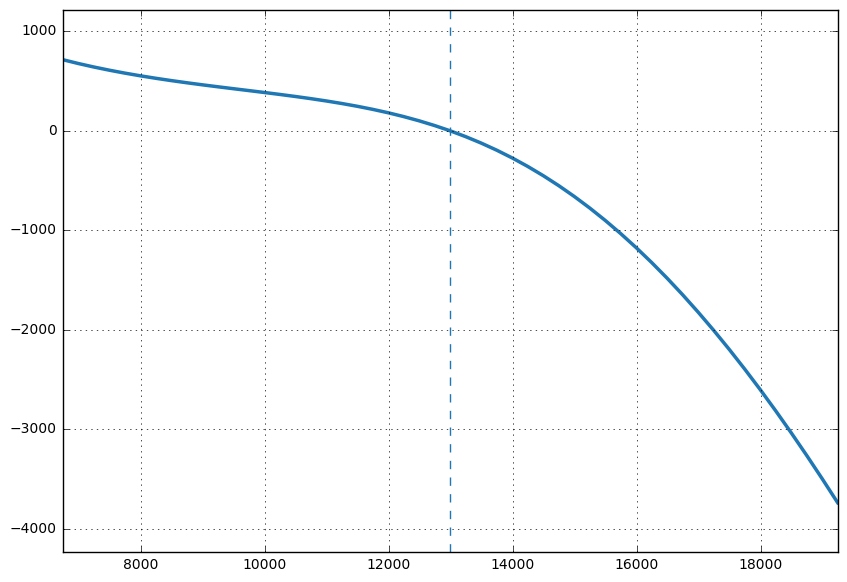

In [629]:
pnl = values-df.loc['total'].PV
plot([S,S], [np.min(pnl)-500, np.max(pnl)+500], '--', lw=1)
plot(spots, pnl, color=tableau[0])
ylim(np.min(pnl)-500,np.max(pnl)+500)
xlim(spots[0],spots[-1])

In [ ]:
option = [inst for inst in instruments if inst['instrumentName'] == ''][0]
S = client.index()['btc']
PV(option, my_surface, overrides={'spot': S})